In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, classification_report,
                              accuracy_score, precision_score,
                              recall_score, f1_score, roc_auc_score,
                              roc_curve)

# 데이터 불러오기
df = pd.read_csv('/content/marketing_click_prediction_cleaned.csv')
print(df.head())
print("\n데이터 정보:")
print(df.info())

# 1.데이터 전처리
# 범주형 변수 처리 (Gender)
df = pd.get_dummies(df, columns=['Gender'])

# 특성(X)과 타겟(y) 분리
X = df.drop('Clicked', axis=1)
y = df['Clicked']

# 학습/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 피처 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("훈련 데이터 형태:", X_train_scaled.shape)
print("테스트 데이터 형태:", X_test_scaled.shape)

    Age  EstimatedSalary  Gender  Clicked
0  30.0           121600    Male        0
1  25.0            91400  Female        0
2  45.0            97700    Male        1
3  35.0            69700  Female        0
4  35.0           149000    Male        0

데이터 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              400 non-null    float64
 1   EstimatedSalary  400 non-null    int64  
 2   Gender           400 non-null    object 
 3   Clicked          400 non-null    int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 12.6+ KB
None
훈련 데이터 형태: (320, 4)
테스트 데이터 형태: (80, 4)


In [28]:
# 2. 기본 모델 성능 비교
models = {
    'Logistic Regression': LogisticRegression(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier()
}

results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    print(f"\n{name} 모델 성능:")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred)
    }

print("\n모델별 성능 요약:")
print(pd.DataFrame(results).T)


Logistic Regression 모델 성능:
Confusion Matrix:
[[50  1]
 [ 1 28]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        51
           1       0.97      0.97      0.97        29

    accuracy                           0.97        80
   macro avg       0.97      0.97      0.97        80
weighted avg       0.97      0.97      0.97        80


K-Nearest Neighbors 모델 성능:
Confusion Matrix:
[[50  1]
 [ 2 27]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        51
           1       0.96      0.93      0.95        29

    accuracy                           0.96        80
   macro avg       0.96      0.96      0.96        80
weighted avg       0.96      0.96      0.96        80


Random Forest 모델 성능:
Confusion Matrix:
[[48  3]
 [ 2 27]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0

In [29]:
# 3. 교차 검증
print("\n교차검증 결과:")
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    print(f"{name}:")
    print(f"교차검증 점수: {cv_scores}")
    print(f"평균: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


교차검증 결과:
Logistic Regression:
교차검증 점수: [0.921875 0.9375   0.9375   0.890625 0.953125]
평균: 0.9281 (+/- 0.0424)
K-Nearest Neighbors:
교차검증 점수: [0.90625  0.9375   0.953125 0.90625  0.953125]
평균: 0.9313 (+/- 0.0424)
Random Forest:
교차검증 점수: [0.921875 0.921875 0.953125 0.890625 0.9375  ]
평균: 0.9250 (+/- 0.0415)


In [32]:
# 4. Stratified K-Fold
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\nStratified K-Fold 결과:")
fold_scores = []
for fold, (train_idx, val_idx) in enumerate(stratified_kfold.split(X_train_scaled, y_train), 1):
    X_train_fold, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    lr_model = LogisticRegression()
    lr_model.fit(X_train_fold, y_train_fold)

    fold_score = lr_model.score(X_val_fold, y_val_fold)
    fold_scores.append(fold_score)
    print(f"Fold {fold} 정확도: {fold_score:.4f}")

print(f"\n평균 정확도: {np.mean(fold_scores):.4f}")


Stratified K-Fold 결과:
Fold 1 정확도: 0.9219
Fold 2 정확도: 0.9062
Fold 3 정확도: 0.9219
Fold 4 정확도: 0.9688
Fold 5 정확도: 0.8906

평균 정확도: 0.9219



최적 하이퍼파라미터:
{'max_depth': 5, 'n_estimators': 50}

최고 교차검증 점수: 0.925

최종 모델 성능:
Confusion Matrix:
[[50  1]
 [ 2 27]]


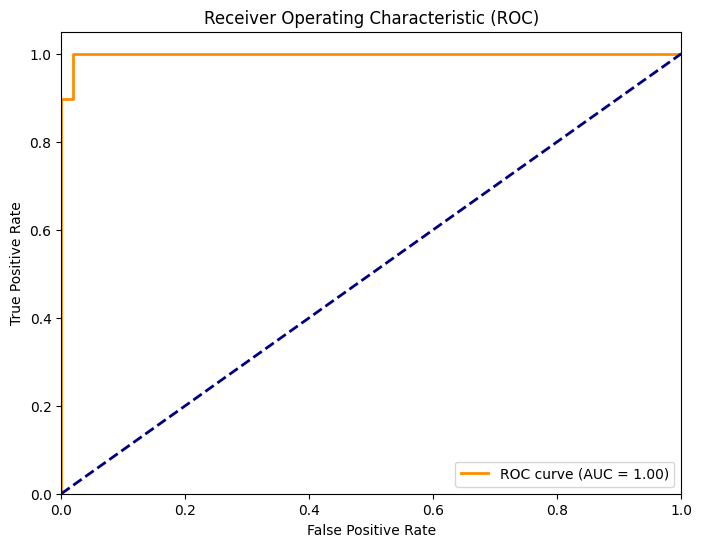


ROC AUC 점수: 0.9980

분류 보고서:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        51
           1       0.96      0.93      0.95        29

    accuracy                           0.96        80
   macro avg       0.96      0.96      0.96        80
weighted avg       0.96      0.96      0.96        80



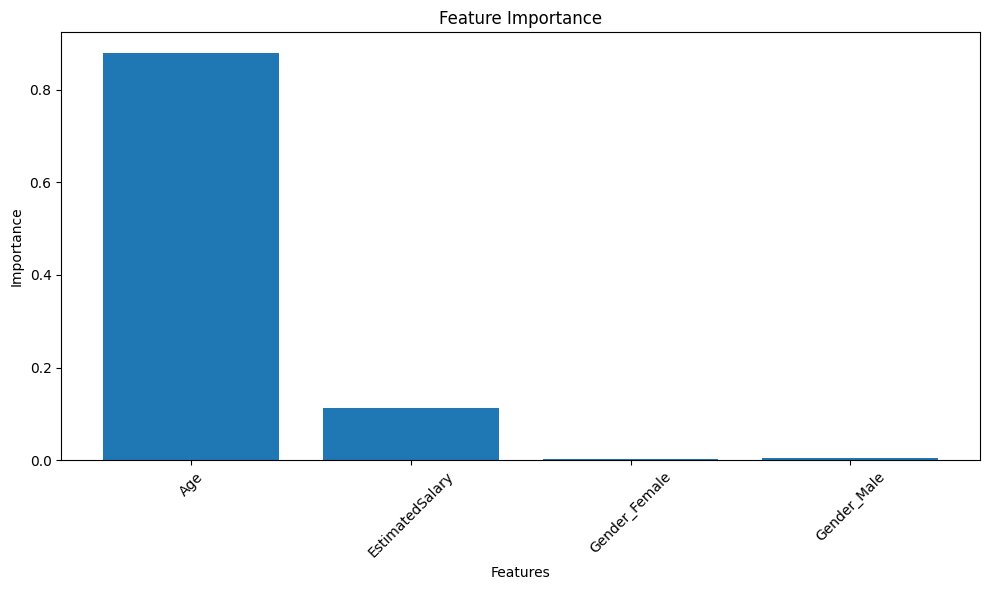

In [39]:
# 5. 하이퍼파라미터 튜닝
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 5, 10]
}

# RandomState 추가하여 재현성 보장
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy'
)
grid_search.fit(X_train_scaled, y_train)

print("\n최적 하이퍼파라미터:")
best_params = grid_search.best_params_
print(best_params)
print("\n최고 교차검증 점수:", grid_search.best_score_)

# 6. 최종 모델 및 보고서
# 최적 하이퍼파라미터로 모델 생성
best_model = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    random_state=42
)
best_model.fit(X_train_scaled, y_train)

# 예측 수행
y_pred_final = best_model.predict(X_test_scaled)

print("\n최종 모델 성능:")
print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred_final)
print(conf_matrix)

# ROC 곡선
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

print(f"\nROC AUC 점수: {roc_auc:.4f}")

# 분류 보고서 출력
print("\n분류 보고서:")
print(classification_report(y_test, y_pred_final))

# 피처 중요도 시각화
feature_importance = best_model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
plt.bar(feature_names, feature_importance)
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()